## SAM PyTriton Client

Demonstrates how to use the SAM PyTriton client to interact with the SAM `vit_h`. 

In [25]:
import cv2
import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt

from pytriton.client import ModelClient

SAM mask generator returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

For this example, the pytriton server returns only the following: 

* `segmentation` 
* `area`

With the following data types:

```
segmentation (h,w) bool
area <class 'int'>
```

Let us borrow the mask image annotation function from SAM.

In [26]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

### Client Inference

Modify the inference function such that the return is an image and a list of masks. Each mask is a dictionary containing the keys `segmentation` and `area`.

Please modify the url path to point to your own server.

SAM `model`s provided in this example are `SAM_h`, `SAM_l` and `SAM_b`.

```python

In [27]:
def infer_model(url="http://localhost:8000", image="images/dog_car.jpg", model="SAM_h"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        outputs = client.infer_sample(image=image)
        segmentation = outputs['segmentation']
        #area = masks['area']
        masks = []
        for i in range(segmentation.shape[0]):
            masks.append({
                'segmentation': segmentation[i,:,:],
                'area': outputs['area'][i],
                "bbox": outputs['bbox'][i],
                # bounding boxes based on segmentation
                #"bboxes" : [min(segmentation[i,:,0]), min(segmentation[i,:,1]), max(segmentation[i,:,0]), max(segmentation[i,:,1])],
                "predicted_iou": outputs['predicted_iou'][i],
                "stability_score": outputs['stability_score'][i],
            })
        
        return image, masks

### Enter the image path or url

For example:

`https://djl.ai/examples/src/test/resources/dog_bike_car.jpg`

or

`images/dog_car.jpg`



In [28]:
image_path = input("Enter image path or URL: ")
if image_path == "":
    image_path = "images/dog_car.jpg"

Perform segmentation

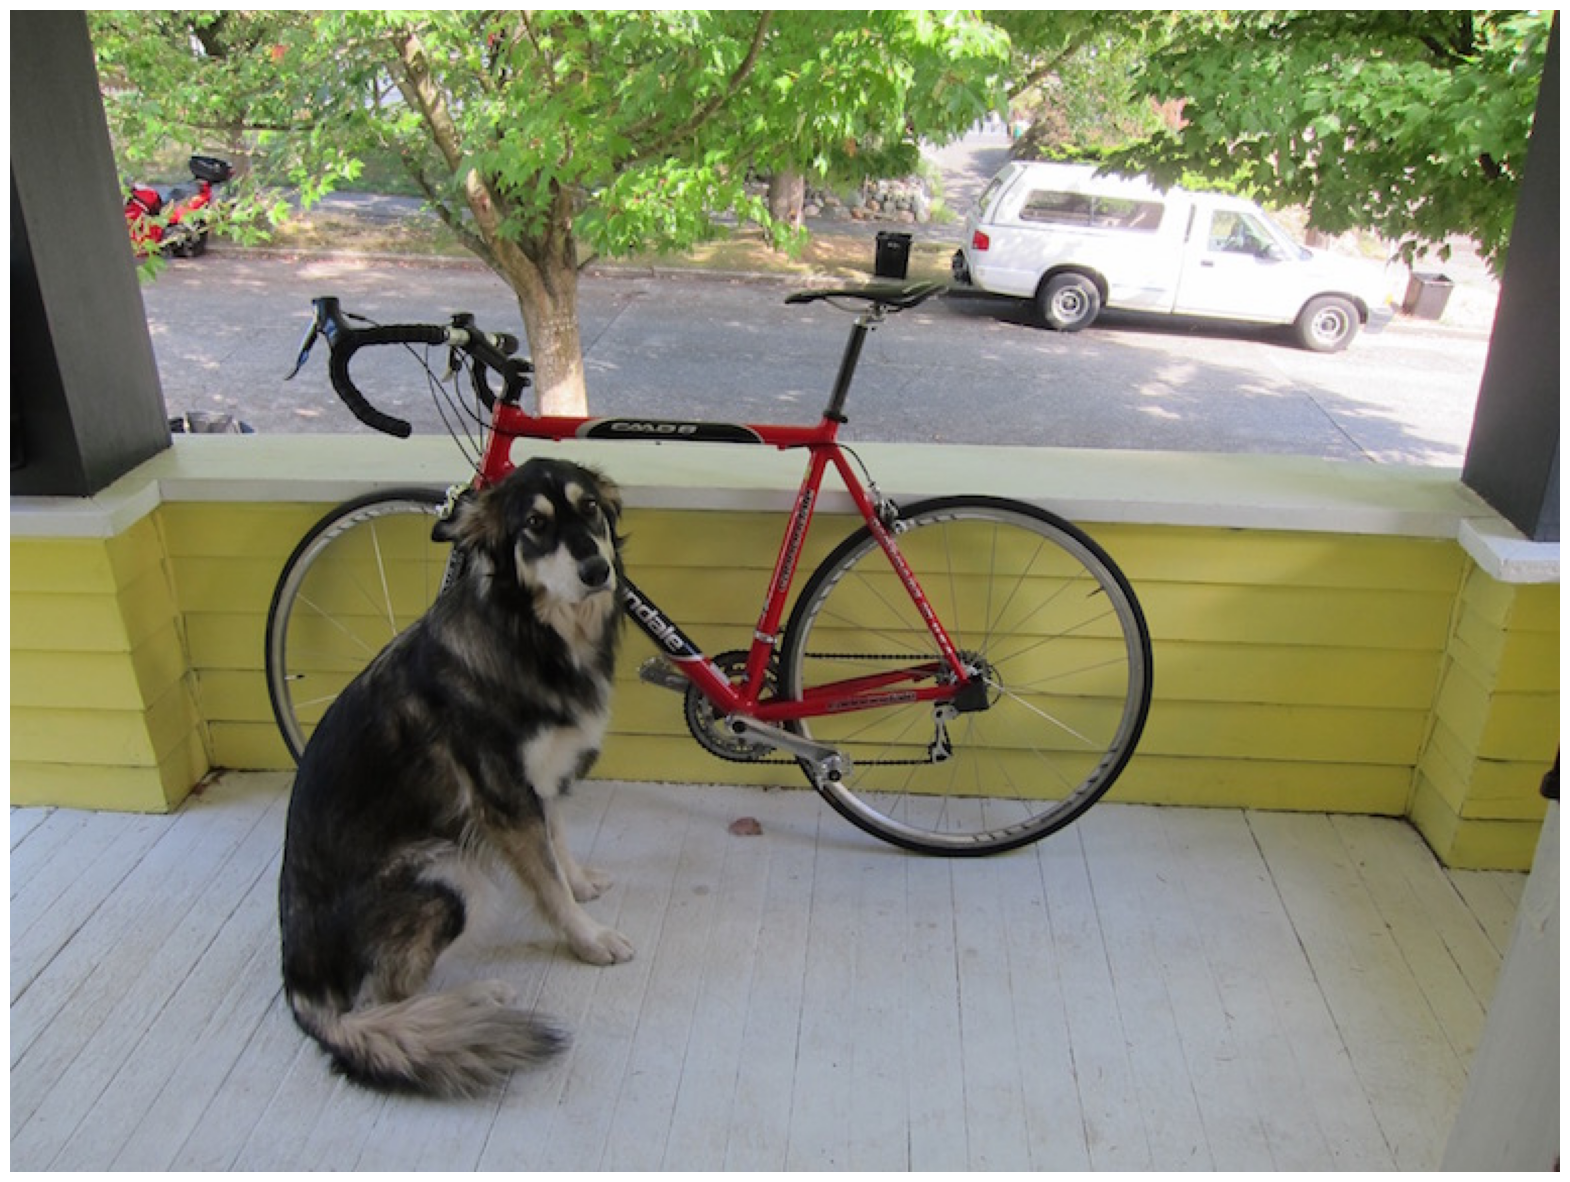

In [29]:
image, masks = infer_model(image=image_path)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

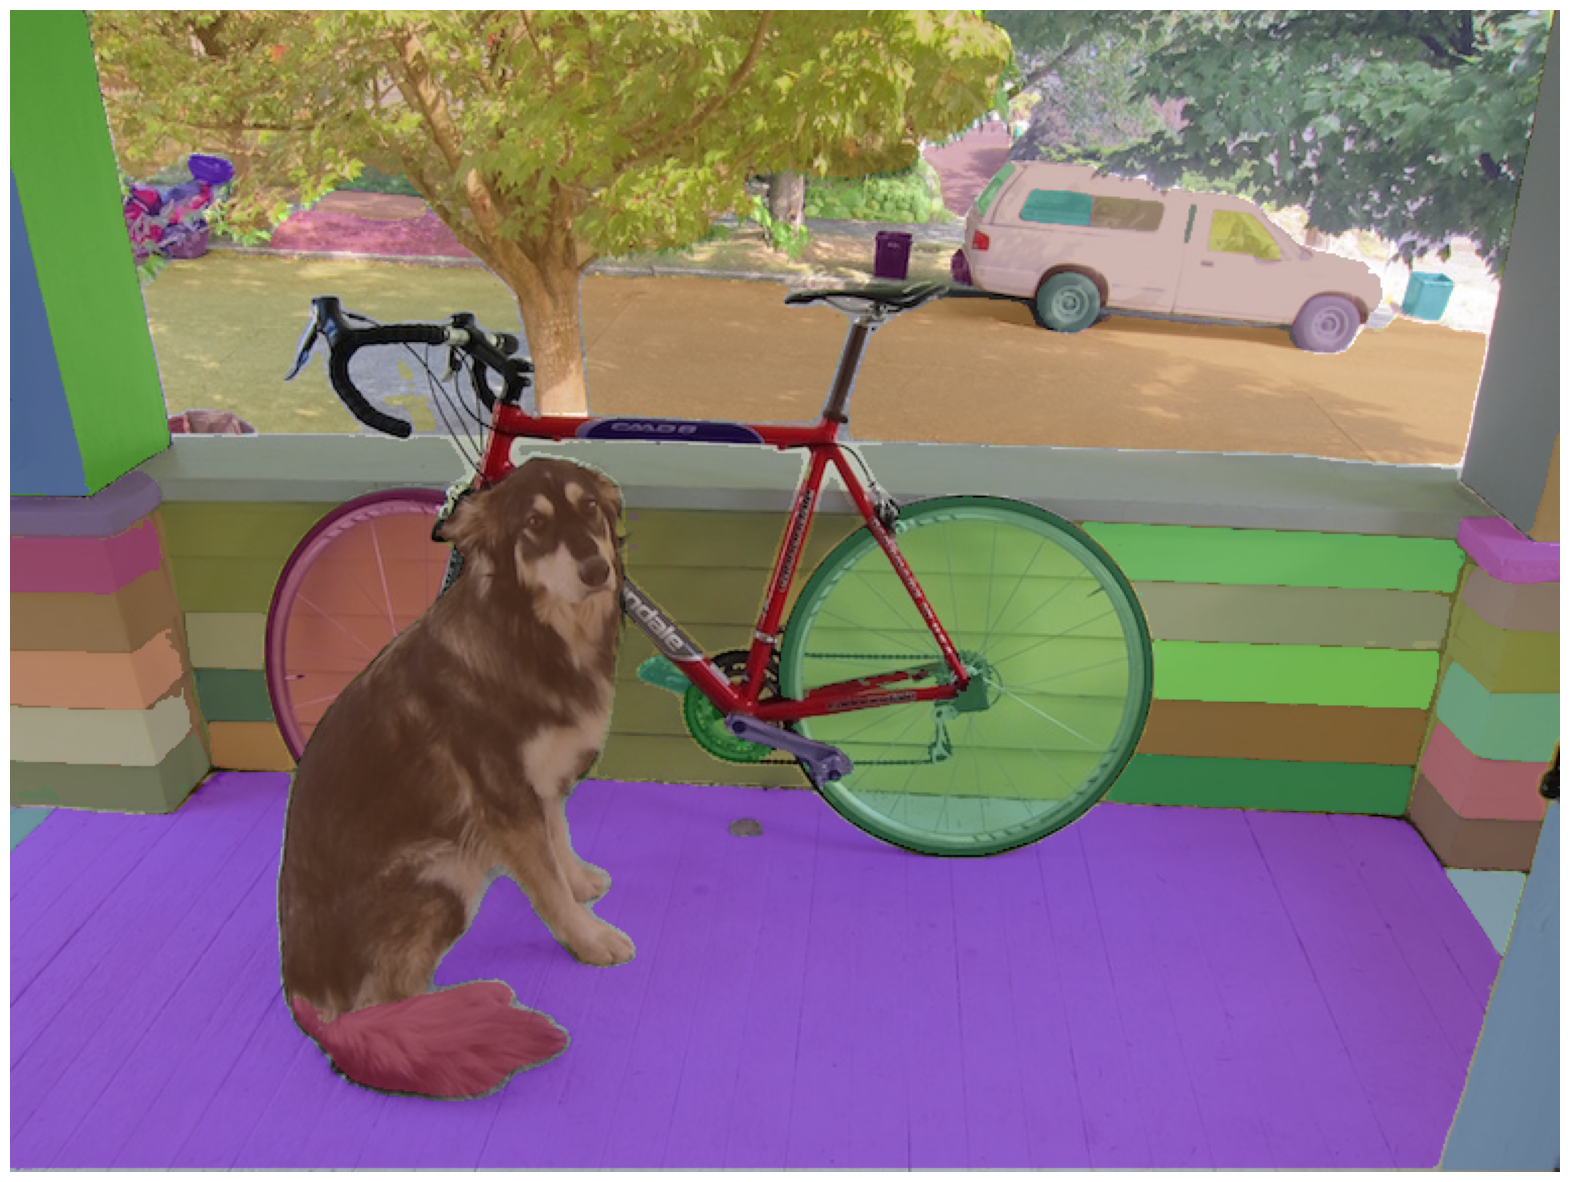

In [30]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

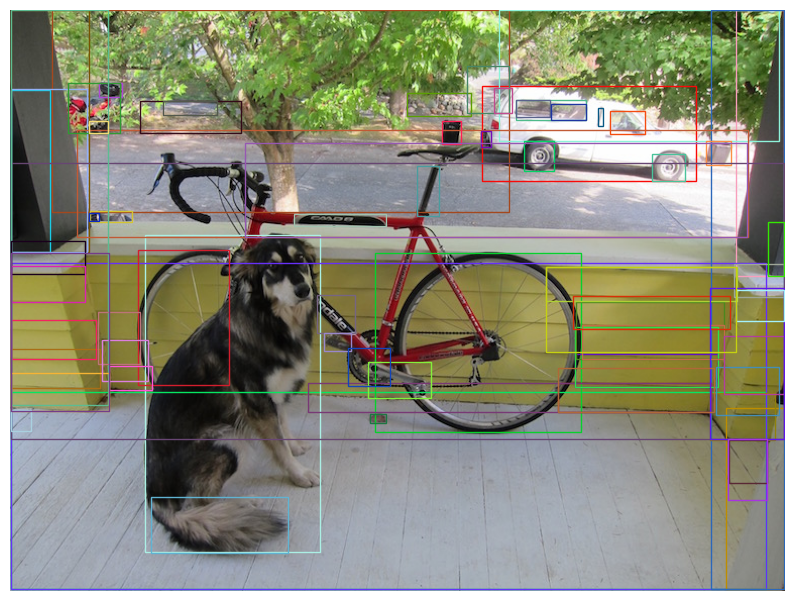

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
ax.axis('off')
for mask in masks:
    if mask["stability_score"] > 0.5:
        x1, y1, w, h = mask["bbox"]
        # make the color random
        color = np.random.rand(3,)
        rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
        ax.add_patch(rect)
        # use the color and add transparency of 0.5
        color = np.append(color, 0.5)
        # add text with white background
        #ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                